In [1]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.io import FortranFile
from nbodykit.lab import * #used for power spectra calulation

from colossus.cosmology import cosmology
cosmo_c = cosmology.setCosmology('planck15') # used for growth factor only

In [6]:
def measure_autopk(array,L):
    mesh = ArrayMesh(array,BoxSize=L)
    r = FFTPower(mesh, mode='1d')
    return r.power

In [2]:
def plot_slice(a1,start):
    cmap = plt.get_cmap('jet')
    start = start
    c = a1[:,start,:]
    #c = scipy.ndimage.interpolation.zoom(c ,order=1, zoom=2)
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111)

    im = plt.imshow((c.T),vmin=-.1,vmax =.1,interpolation='bilinear',origin='lower',aspect='auto',cmap=cmap)
    ax.set_aspect('equal')

    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", "5%", pad="2%")
    cb = plt.colorbar(im,orientation='vertical',cax=cax)
    cb.ax.get_yaxis().labelpad = 0.
    plt.show()

In [4]:
def pol2cart(r, phi):
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    return(x, y)

In [3]:
def noise_real(nc):
    np.random.seed(1)
    a = np.random.normal(loc=0, scale=1, size=(nc,nc,nc))
    deltapk = np.fft.fftn(a)/np.sqrt(nc**3)
    return deltapk 

In [7]:
L=512
nc=256
wn = noise_real(nc)

In [8]:
a = measure_autopk(wn,L)

[]

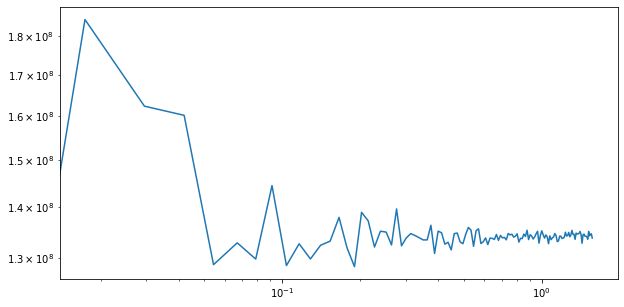

In [9]:
plt.figure(figsize=(10,5))
plt.plot(a['k'],a['power'])
plt.loglog()

In [10]:
#use your initial redshift and linear power spectrum file of your choice 
z_init=100
k,p = np.loadtxt('Pk.input_zinit_normalized_at_z0.DAT',unpack=True)
p*=cosmo_c.growthFactor(z_init)**2

In [11]:
def k_box(nc,L):
    kfac = 2.*np.pi/L
    k= np.fft.fftfreq(nc,d=1./nc/kfac) #d controls spacing
    a = np.transpose(np.indices((nc,nc,nc)).T, (2, 1, 0, 3)) #1 grid cell 3 coordinates
    k2=(k[a]**2).sum(axis=-1) # each grid cell is sum of squares of coordinates
    return np.sqrt(k2).astype(np.float16)

In [12]:
kbox = k_box(nc,L)
Pk_box = np.interp(kbox,k,p)

In [67]:
"random ICs"
wnpk = wn *np.sqrt(Pk_box/L**(3)*nc**(6))
deltapk = np.fft.ifftn(wnpk)

In [68]:
"paired random"
wnpk_abs = np.abs(wnpk)
wnpk_phase = np.angle(wnpk)
re,imag = pol2cart(wnpk_abs,-wnpk_phase)
wnpkp = re + 1J*imag
deltapkp = np.fft.ifftn(wnpkp)

In [69]:
"fixed amplitudes"
re,imag = pol2cart(np.sqrt(Pk_box/L**(3)*nc**(6)),wnpk_phase)
wnpkfix = re+1J*imag
deltapkfix = np.fft.ifftn(wnpkfix)

In [72]:
"paired fixed amplitudes"
ap , bp = pol2cart(np.sqrt(Pk_box/L**(3)*nc**(6)),-wnpk_phase)
deltakp_fix = ap + bp*1J
deltapkfixp = np.fft.ifftn(deltakp_fix)

In [73]:
pk = measure_autopk(deltapk.real,L)
pkp = measure_autopk(deltapkp.real,L)
pkfix = measure_autopk(deltapkfix.real,L)
pkfixp = measure_autopk(deltapkfixp.real,L)



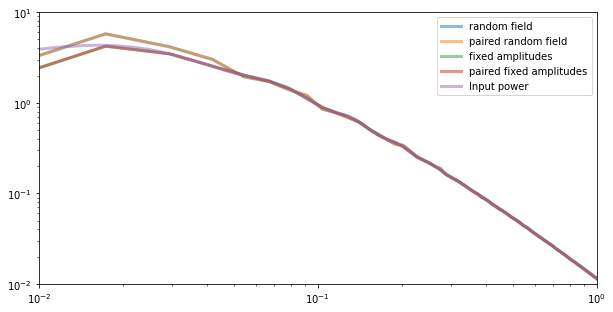

In [83]:
plt.figure(figsize=(10,5))
plt.plot(pk['k'].real,pk['power'].real,lw=3,alpha=0.5,label="random field")
plt.plot(pkp['k'].real,pkp['power'].real,lw=3,alpha=0.5,label="paired random field")
plt.plot(pkfix['k'].real,pkfix['power'].real,lw=3,alpha=0.5,label="fixed amplitudes")
plt.plot(pkfixp['k'].real,pkfixp['power'].real,lw=3,alpha=0.5,label="paired fixed amplitudes")
plt.plot(k,p,alpha=0.5,lw=3,label="Input power")
plt.loglog()
plt.xlim(0.01,1)
plt.ylim(1E-2,1E1)
plt.legend()

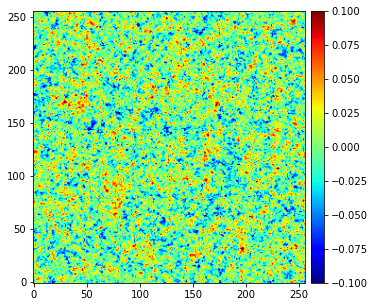

In [79]:
plot_slice(deltapk.real,128) #random

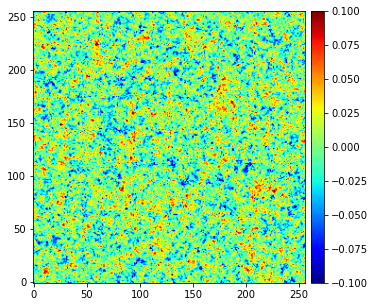

In [81]:
plot_slice(deltapkp.real,128)#random paired

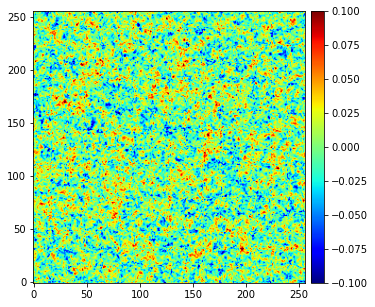

In [64]:
plot_slice(deltapkfix.real,128) #fixed amp

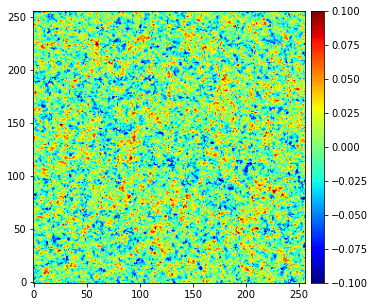

In [82]:
plot_slice(deltapkfixp.real,128) # paired fixed amp

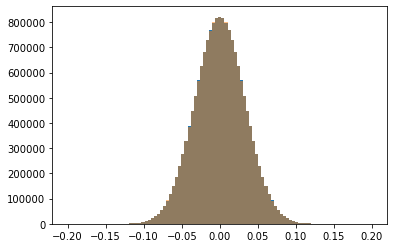

In [84]:
_ = plt.hist(deltapk.real.ravel(),bins=np.linspace(-0.2,0.2,100))
_ = plt.hist(deltapkfix.real.ravel(),bins=np.linspace(-0.2,0.2,100),alpha=0.5)

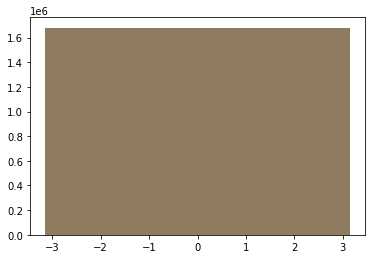

In [39]:
_=plt.hist(wnpk_phase.ravel())
_=plt.hist(wnpkfix_phase.ravel(),alpha=0.5)

[]

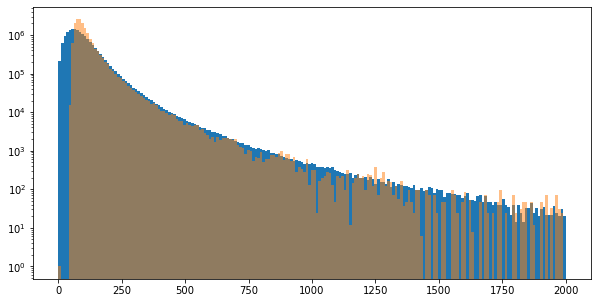

In [40]:
plt.figure(figsize=(10,5))
_=plt.hist(wnpk_abs.ravel(),bins=np.linspace(0,2000,200))
_=plt.hist(wnpkfix_abs.ravel(),bins=np.linspace(0,2000,200),alpha=0.5)

plt.semilogy()


[]

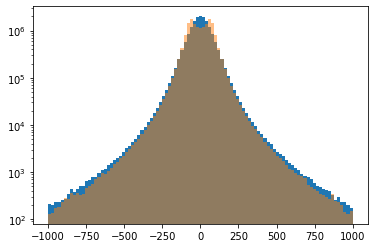

In [41]:
_=plt.hist(wnpk.real.ravel(),bins=np.linspace(-1000,1000,100))
_=plt.hist(wnpkfix.real.ravel(),bins=np.linspace(-1000,1000,100),alpha=0.5)
plt.semilogy()

[]

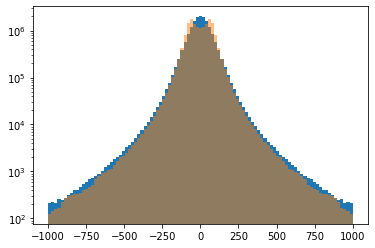

In [42]:
_=plt.hist(wnpk.imag.ravel(),bins=np.linspace(-1000,1000,100))
_=plt.hist(wnpkfix.imag.ravel(),bins=np.linspace(-1000,1000,100),alpha=0.5)
plt.semilogy()

In [94]:
def write_music(dens):
    seed=1
    header = np.array([nc,nc,nc,seed],dtype=np.int32)
    file_out = "IC.dat"
    f = FortranFile(file_out, 'w')
    f.write_record((header))
    for i in range(nc): #z dim
        f.write_record(dens[:,:,i])
    f.close()
    return f